# Predicting the Status of Wells Across Tanzania

Exploration done by WellWatchers Avi Saraf, Lily Zhang, and Cindy Zhao.

## Motivation and Background

###  Why water?
As we've realized the importance of access to clean water on education, income, health, and female empowerment, nonprofit and governmental organizations alike have been increasingly targeting clean water issues in developing countries. Especially in the isolated rural areas of Tanzania, communities lose out when women spend a significant fraction of their time walking miles to collect water. To alleviate this problem, the aforementioned organizations have been building water pumps.

###  When Water Pumps Fail
Water pumps are not without their problems, however. Ideally, the water pumps would remain viable for the communities it serves for forever, but like all infrastructure, water pumps are prone to break down without proper maintenance. Hence, we would like to predict the status of a well status: is it functional, and if so, does it need repairs? What features are more important to determining the success of a well? 

To the best of our knowledge, while these organizations target the water shortages by building wells, not much effort is put into modeling the success of these wells and studying the data. As data scientists deeply interested in social impact and inspired by DrivenData's "Pump it Up: Data Mining the Water Table" competition linked below, we set out to ask how we can better identify important predictors of a functional well. 

http://www.drivendata.org/competitions/7/page/23/

## Data Set Source
As provided and delineated by DrivenData, our data set was collected by Taarifa and the Tanzanian Ministry of Water. It contains information covering around 30 features and 60,000 wells. As we will later describe, we clean the first part of it in R and continue cleaning here.

## Objectives

Throughout our analysis, we seek to answer three main questions:
1. How does well functionality vary across Tanzania's geographical regions?
2. What features are important in determining whether a well is functional, in need of repair, or outright dysfunctional?
3. What is the best model to predict how operational a well built in the future might be?


## Overview

After cleaning, our modeling will generally follow consist of the following outline:
1. Cleaning
2. EDA
3. Classification
    - kNN
    - Naive Bayes
    - SVM
    - Random Forest
4. Regression
5. Summary

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

###  Data Source

We first cleaned our data in R per the link cited below. We adjusted our cleaning to fit our own needs, however, and the code can be found under "clean_data.R". Essentially, we drop a few features with far too many levels (district code, for example, since geographical location is already reflected in subvillage), as well as features that are clearly not useful, such as the name of the waterpoint (wpt_name). We also construct two features, one for the number of days since January 1, 2014 (as a measure of the time the well's functionality was recorded) and one for the month, recorded as a factor. We were interested in seeing whether the timeframe of recording the well's status influenced its functionality.

Original Source: https://www.dropbox.com/s/rmdbv8ynmfkv5uf/clean_data.R?dl=0

In [2]:
df_values = pd.read_csv("clean_training_set_values.csv")
df_labels = pd.read_csv("training_set_labels.csv")

In [3]:
#merge the features (i.e. values) and the labels into one DataFrame
df = pd.merge(df_values, df_labels, on="id")

In [4]:
df.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,date_recorded_offset_days,date_recorded_month,status_group
0,69572,6000,Other,1390,Other,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1024,Mar,functional
1,8776,0,Other,1399,Other,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,301,Mar,functional
2,34310,25,Other,686,Other,37.460664,-3.821329,Pangani,Majengo,Manyara,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,310,Feb,functional
3,67743,0,Unicef,263,Other,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,338,Jan,non functional
4,19728,0,Other,0,Other,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,903,Jul,functional


##  Exploratory Data Analysis & Data Preparation

###  Labels

Our labels are under the column "status_group" and are one of the three following values:
- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational

###  Categorical Features

We have the following categorical variables:
- funder - Who funded the well
- installer - Organization that installed the well
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- public_meeting (T/F)
- permit (T/F) - If the waterpoint is permitted
- scheme_management - Who operates the waterpoint
- permit (T/F)
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- quantity - The quantity of water (dry, enough, insufficient, seasonal, unknown)
- date_recorded_month - The month of the date the row was entered


###  Continuous Features

We have less quantitative features:
- amount_tsh - Total static head (amount of water available to waterpoint)
- gps_height - Altitude of the well
- population - Population around the well
- date_recorded_offset_days

Note that we originally also have access to the well's latitude and longitude, which we use in the visualizations. However, as they are unique for each well, we drop both features in our cleaning.

In each of our models, we must consider how to best use the categorical features--in fact, after EDA we eventually decided that our preferred approach was to convert the categorical feature into indicator variables, to be seen in df_formatted. 

##  Mapping the Data

We begin our EDA by creating maps of the data to determine whether there are any strong links between any of the features and the status of the wells. We used matplotlib's basemap feature to provide the map and plotted each well using the latitude and longitude values, coloring on different features.

Note: If running this code, you may need to install Basemap first.

In [52]:
from mpl_toolkits.basemap import Basemap

# adapated from http://matplotlib.org/basemap/users/examples.html

def mapwell(df, category, use_colors = False, cmap = False, ax = False, lat_0=-6,lon_0=34,llcrnrlon=28, llcrnrlat=-12,
                urcrnrlon=41, urcrnrlat=0):
    
    # setup cylindrical basemap.
    m = Basemap(projection='cyl',
                resolution='h',
                lat_0=lat_0,lon_0=lon_0, 
                llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, 
                ax=ax)

    # draw coastlines.
    m.drawcoastlines()

    # draw countries borders.
    m.drawcountries()

    # draw a boundary around the map, fill the background.
    # this background will end up being the ocean color, since
    # the continents will be drawn on top.
    m.drawmapboundary(fill_color='aqua')

    # fill continents, set lake color same as ocean color.
    m.fillcontinents(color='white',lake_color='aqua', zorder = 0)

    # create scatter plot
    if use_colors:
        m.scatter(df.longitude.values, df.latitude.values, marker = 'o',zorder = 1, latlon=True, alpha = 0.05, 
                  c=[use_colors[x] for x in category],s=30,lw=0)
    if cmap: 
        tot = float(len(pd.Series(category.ravel()).unique()))
        print pd.Series(category.ravel()).unique()
        use_colors2 = {}
        for index,x in enumerate(pd.Series(category.ravel()).unique()):
            use_colors2[x] = cmap(float(index)/tot) 
    
        m.scatter(df.longitude.values, df.latitude.values, marker = 'o',zorder = 1, latlon=True, alpha = 0.05, 
                   c=[use_colors2[x] for x in category],s=30,lw=0)

['Iringa' 'Mara' 'Manyara' 'Mtwara' 'Kagera' 'Tanga' 'Shinyanga' 'Tabora'
 'Pwani' 'Ruvuma' 'Kilimanjaro' 'Rukwa' 'Mwanza' 'Kigoma' 'Lindi' 'Dodoma'
 'Arusha' 'Mbeya' 'Singida' 'Morogoro' 'Dar es Salaam']


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


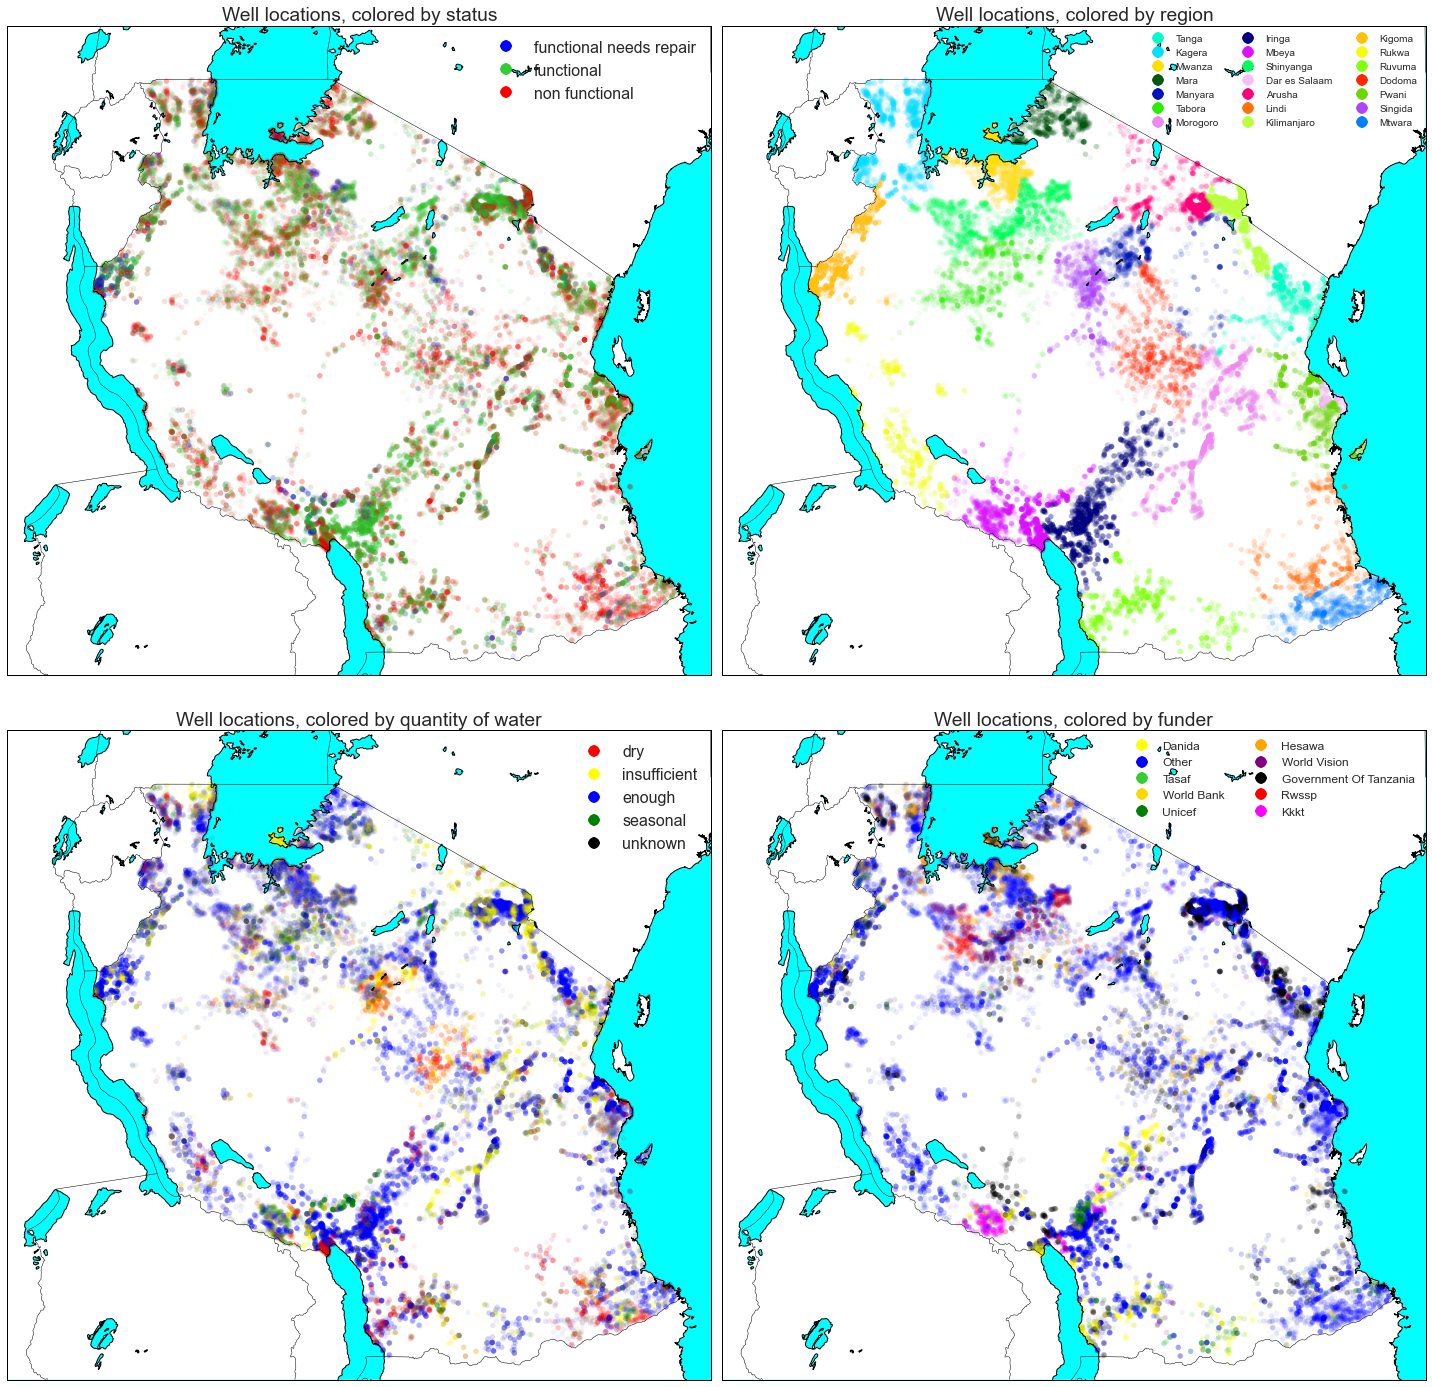

In [53]:
# create plot
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(20, 20),tight_layout = True)

# status map
use_colors = {"functional": "limegreen", "non functional": "red", "functional needs repair": "blue"}
mapwell(df, df.status_group, use_colors = use_colors, ax = ax1)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors.values()]
ax1.legend(markers, use_colors.keys(), numpoints=1)
ax1.set_title("Well locations, colored by status")

# regional wells map
import matplotlib.cm as cm
mapwell(df, df.region, cmap = cm.gist_ncar, ax = ax2)
ax2.set_title("Well locations, colored by region")
tot = float(len(pd.Series(df.region.ravel()).unique()))
use_colors2 = {}
for index,x in enumerate(pd.Series(df.region.ravel()).unique()):
    use_colors2[x] = cm.gist_ncar(float(index)/tot) 
markers2 = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors2.values()]
ax2.legend(markers2, use_colors2.keys(), numpoints=1, ncol=3, fontsize=10)

# water quantity map
use_colors3 = {"enough": "blue", "insufficient": "yellow", "dry": "red", "seasonal": "green", "unknown": "black"}
markers3 = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors3.values()]
mapwell(df, df.quantity, use_colors = use_colors3, ax = ax3)
ax3.set_title("Well locations, colored by quantity of water")
ax3.legend(markers3, use_colors3.keys(), numpoints=1)

# funder map
use_colors4 = {'Other':'blue', 'Unicef':'green', 'Rwssp':'red', 'Danida':'yellow', 'World Vision':'purple', 'Hesawa':'orange', 
               'Government Of Tanzania':'black', 'Kkkt':'magenta', 'Tasaf':'limegreen', 'World Bank':'gold'}
markers4 = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors4.values()]
ax4.legend(markers4,use_colors4.keys(),numpoints=1, loc=1, ncol=2, fontsize=12)
mapwell(df[[~x for x in df.funder.isnull()]], df.funder[[~x for x in df.funder.isnull()]], use_colors = use_colors4, ax = ax4)
ax4.set_title("Well locations, colored by funder")

plt.show()

####  Observations 

What do we notice off the bat from these visualizations?
- Iringa seems to have a lot of functional wells. Later on, we correlate the features with the labels and will note that indeed, an indicator variable for being in Iringa is positively correlated with functional wells, more so than any of the other regions. Once we finish our general exploration, we will take a deeper dive into exploring Iringa's wells.
- On the other hand, Mtwara and Kigoma seem to have a lot of non-functional wells.
- As we might expect from common sense, a lot of the wells that are dry are also non functional. As we will see, the indicator variable for a dry quantity of water, too, will appear in the most anti-correlated features for functional status.
- There seems to be no obvious connection between funder and well status.

###  Redundancies

Now we inspect the unique values of each of these columns. We find that some of the columns describe the same feature but have slightly different sets of values. This is particularly the case with features that also have a corresponding '_ _group_' column as well. Although the non-group features are more specific, we chose to use the grouped features as we quickly found that attempting to split up an even larger number of features into indicator variables was computationally and time-intensive. 

Ideally, if we had even more time and faster processing speeds, we would love to further explore the more specific feature set.

In [5]:
print pd.Series(df.extraction_type.ravel()).unique()
#less specific
print pd.Series(df.extraction_type_group.ravel()).unique()
print pd.Series(df.extraction_type_class.ravel()).unique()

['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi']
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']


In [6]:
#payment and payment type are almost equivalent
print pd.Series(df.payment.ravel()).unique()
print pd.Series(df.payment_type.ravel()).unique()

['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']


In [7]:
#the difference here is the addition of 'communal standpipe multiple' in waterpoint_type
print pd.Series(df.waterpoint_type.ravel()).unique()
#less specific
print pd.Series(df.waterpoint_type_group.ravel()).unique()

['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
['communal standpipe' 'hand pump' 'other' 'improved spring' 'cattle trough'
 'dam']


In [7]:
print pd.Series(df.water_quality.ravel()).unique()
#less specific
print pd.Series(df.quality_group.ravel()).unique()

['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']


In [8]:
#less specific
#'borehole' includes 'machine dbh' and 'hand dtw'
#'river/lake' includes 'river' and 'lake'
#'other' includes 'other' and 'unknown'
print pd.Series(df.source_type.ravel()).unique()
print pd.Series(df.source.values.ravel()).unique()
#source and source_type are nested within source_class
print pd.Series(df.source_class.values.ravel()).unique()

['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other' 'shallow well'
 'river' 'hand dtw' 'lake' 'unknown']
['groundwater' 'surface' 'unknown']


In [9]:
#management is nested within management_group
print pd.Series(df.management.ravel()).unique()
print pd.Series(df.management_group.ravel()).unique()

['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
['user-group' 'other' 'commercial' 'parastatal' 'unknown']


As aforementioned, we see that some of these features are redundant, so we delete one of the repeated columns. Regarding the features/feature_group label pairs, there is a nesting structure, but it is so slight that we just delete one of the columns; otherwise, we would most likely run into problems of collinearity. We have two new dataframes, one with only the feature_group labels (less specific), and one with only the feature labels (more specific). We will try our regression on the less specific df_new first but keep df_new1 just in case.

In [10]:
df_new1 = df.drop(['quantity_group','extraction_type_group','waterpoint_type_group','quality_group','source_type','payment', 'construction_year','latitude','longitude', 'subvillage','id'], axis=1)
df_new = df.drop(['quantity_group','extraction_type','waterpoint_type','quality_group','source','payment', 'construction_year','latitude','longitude','subvillage','id'], axis=1)

In [11]:
df_new.head()

,amount_tsh,funder,gps_height,installer,basin,region,population,public_meeting,scheme_management,permit,...,management_group,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type_group,date_recorded_offset_days,date_recorded_month,status_group
0,6000,Other,1390,Other,Lake Nyasa,Iringa,109,True,VWC,False,...,user-group,annually,soft,enough,spring,groundwater,communal standpipe,1024,Mar,functional
1,0,Other,1399,Other,Lake Victoria,Mara,280,NaN,Other,True,...,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,301,Mar,functional
2,25,Other,686,Other,Pangani,Manyara,250,True,VWC,True,...,user-group,per bucket,soft,enough,dam,surface,communal standpipe,310,Feb,functional
3,0,Unicef,263,Other,Ruvuma / Southern Coast,Mtwara,58,True,VWC,True,...,user-group,never pay,soft,dry,borehole,groundwater,communal standpipe,338,Jan,non functional
4,0,Other,0,Other,Lake Victoria,Kagera,0,True,NaN,True,...,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,903,Jul,functional


###  Summary of Nested Features

In df_new, we know that:
- management is nested within management_group
- source is nested within source_class
- extraction is nested within extraction_type_class
- subvillage is nested within region

###  Summary Groupings of Categorical Variables
The features dealing with the management of the well include:
- funder
- installer
- scheme_management
- management/management_group
- payment_type
- permit (T/F)

The features dealing with the creation of the well include:
- extraction/extraction_type_class
- waterpoint_type

The features dealing with time include: 
- construction_year
- date_recorded_offset_days (int; how long ago it was constructed, from the date recorded)
- date_recorded_month

The features dealing with natural properties include:
- water_quality
- source/source_class
- amount_tsh
- quantity
- basin

The features dealing with the community using the well and location include:
- subvillage
- region
- population
- public_meeting (T/F)
- gps_height
- longitude
- latitude

We may later consider these general categories in our multilevel modeling.

In [12]:
#here are all the remaining columns after cleaning for redundancies
df_new.columns

Index([u'amount_tsh', u'funder', u'gps_height', u'installer', u'basin',
       u'region', u'population', u'public_meeting', u'scheme_management',
       u'permit', u'extraction_type_group', u'extraction_type_class',
       u'management', u'management_group', u'payment_type', u'water_quality',
       u'quantity', u'source_type', u'source_class', u'waterpoint_type_group',
       u'date_recorded_offset_days', u'date_recorded_month', u'status_group'],
      dtype='object')

Now that we've cleaned up some of our variables, let's take a look at a few more plots. Since we were unable to identify an obvious relationship between funder and well status, we take a look at that. We are also interested in learning about the time span of when our information was collected.

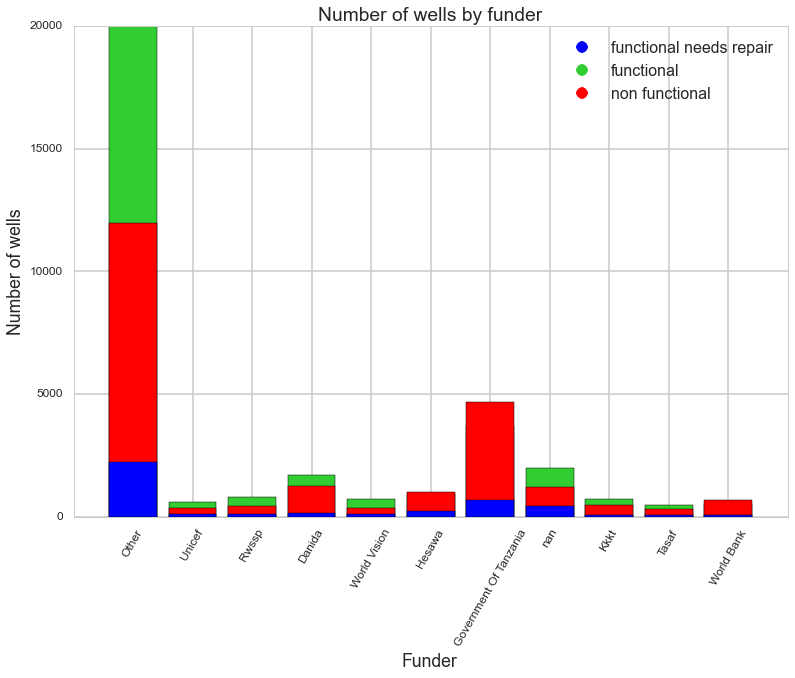

In [54]:
#for funders
functional = df_new[df_new['status_group']=='functional']['funder'].tolist()
non_functional = df_new[df_new['status_group']=='non functional']['funder'].tolist()
needs_repair = df_new[df_new['status_group']=='functional needs repair']['funder'].tolist()

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

categories = pd.Series(df_new.funder.values.ravel()).unique()
value_freq_funct = []
value_freq_nonf = []
value_freq_repair = []
categories_num = range(1,len(categories)+1)
for value in categories:
    value_freq_funct.append(functional.count(value))
    value_freq_nonf.append(non_functional.count(value))
    value_freq_repair.append(needs_repair.count(value))
fig.set_size_inches(8, 5)
plt.bar(categories_num,value_freq_funct,align='center',color='limegreen')
plt.bar(categories_num,value_freq_nonf,align='center',color='r')
plt.bar(categories_num,value_freq_repair,align='center',color='b')
plt.xticks(categories_num, categories, rotation = 60)
plt.legend(markers,use_colors.keys())
plt.ylabel("Number of wells")
plt.xlabel("Funder")
plt.title("Number of wells by funder")

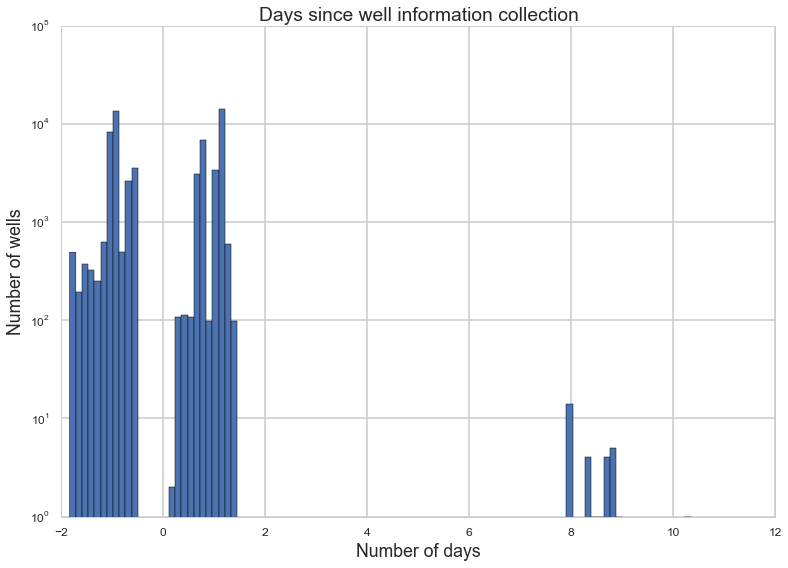

In [55]:
plt.hist(df_new.date_recorded_offset_days,bins=100,log=True)
plt.title("Days since well information collection")

plt.xlabel("Number of days")
plt.ylabel("Number of wells")

##  Splitting the Data into a Training and Test Set

Similar to the previous work in this course, we use sklearn's train_test_split library.

In [13]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(xrange(df_new.shape[0]), train_size=0.7)
mask=np.ones(df_new.shape[0])
mask[train]=1
mask[test]=0
mask = (mask==1)

##  Standardize

Now standardize our quantitative variables so they can be compared. To reiterate, these variables are amount_tsh, gps_height, population, and date_recorded_offset_days.

In [14]:
from sklearn import preprocessing as prepr
STANDARDIZABLE = [u'amount_tsh', u'gps_height', u'population', u'date_recorded_offset_days']
scaler = prepr.StandardScaler().fit(df_new[mask][STANDARDIZABLE])
df_new[STANDARDIZABLE] = scaler.transform(df_new[STANDARDIZABLE])
df_new[STANDARDIZABLE].head()

,amount_tsh,gps_height,population,date_recorded_offset_days
0,1.863770,1.045159,-0.155695,1.144795
1,-0.102736,1.058167,0.212111,-1.018569
2,-0.094542,0.027690,0.147584,-0.991639
3,-0.102736,-0.583660,-0.265392,-0.907857
4,-0.102736,-0.963765,-0.390145,0.782739


Now that we've standardized, we ask ourselves: Do any of the variables in STANDARDIZABLE seem like useful indicators for well status? Let's see by plotting these variables and seeing how their distributions differ across the labels. 

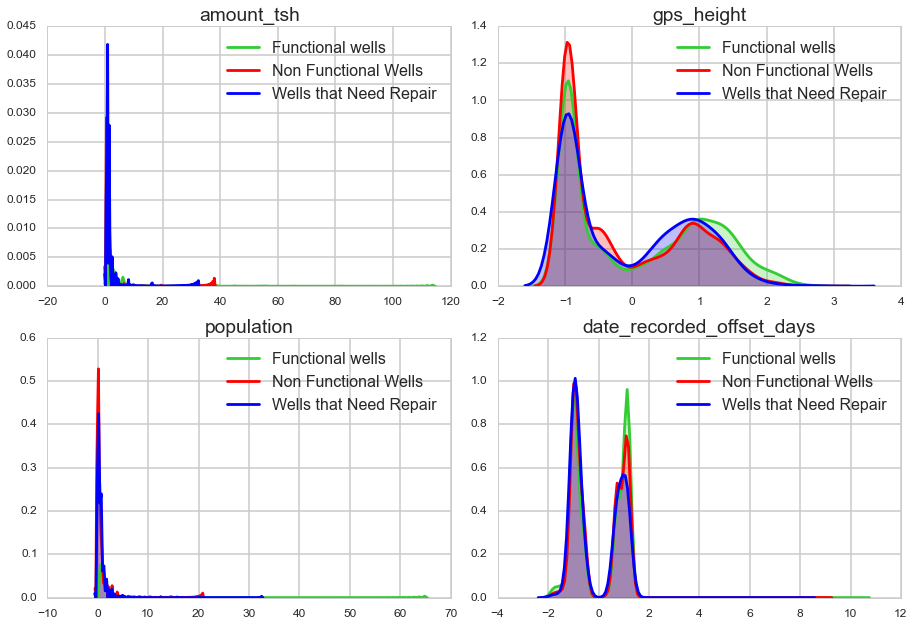

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2)

for i, feature in enumerate(STANDARDIZABLE):
    ax = axes[i/2, i%2]
    sns.kdeplot(df_new[df_new['status_group']=='functional'][feature], ax=ax, shade=True,color='limegreen', label="Functional wells")
    sns.kdeplot(df_new[df_new['status_group']=='non functional'][feature], ax=ax, shade=True,color='red', label="Non Functional Wells")
    sns.kdeplot(df_new[df_new['status_group']=='functional needs repair'][feature], ax=ax, shade=True,color='blue', label="Wells that Need Repair")
    ax.set_title(feature)

fig.tight_layout()

We do the same for the categorical variables.

In [15]:
CATEGORICAL = [u'funder', u'installer', u'basin', u'region',
               u'public_meeting', u'scheme_management', u'permit',
               u'extraction_type_group', u'extraction_type_class',
               u'management', u'management_group', u'payment_type', u'water_quality',
               u'quantity', u'source_type', u'source_class', u'waterpoint_type_group', u'date_recorded_month']
for variable in CATEGORICAL:
    df_new[variable] = df_new[variable].astype('category')  

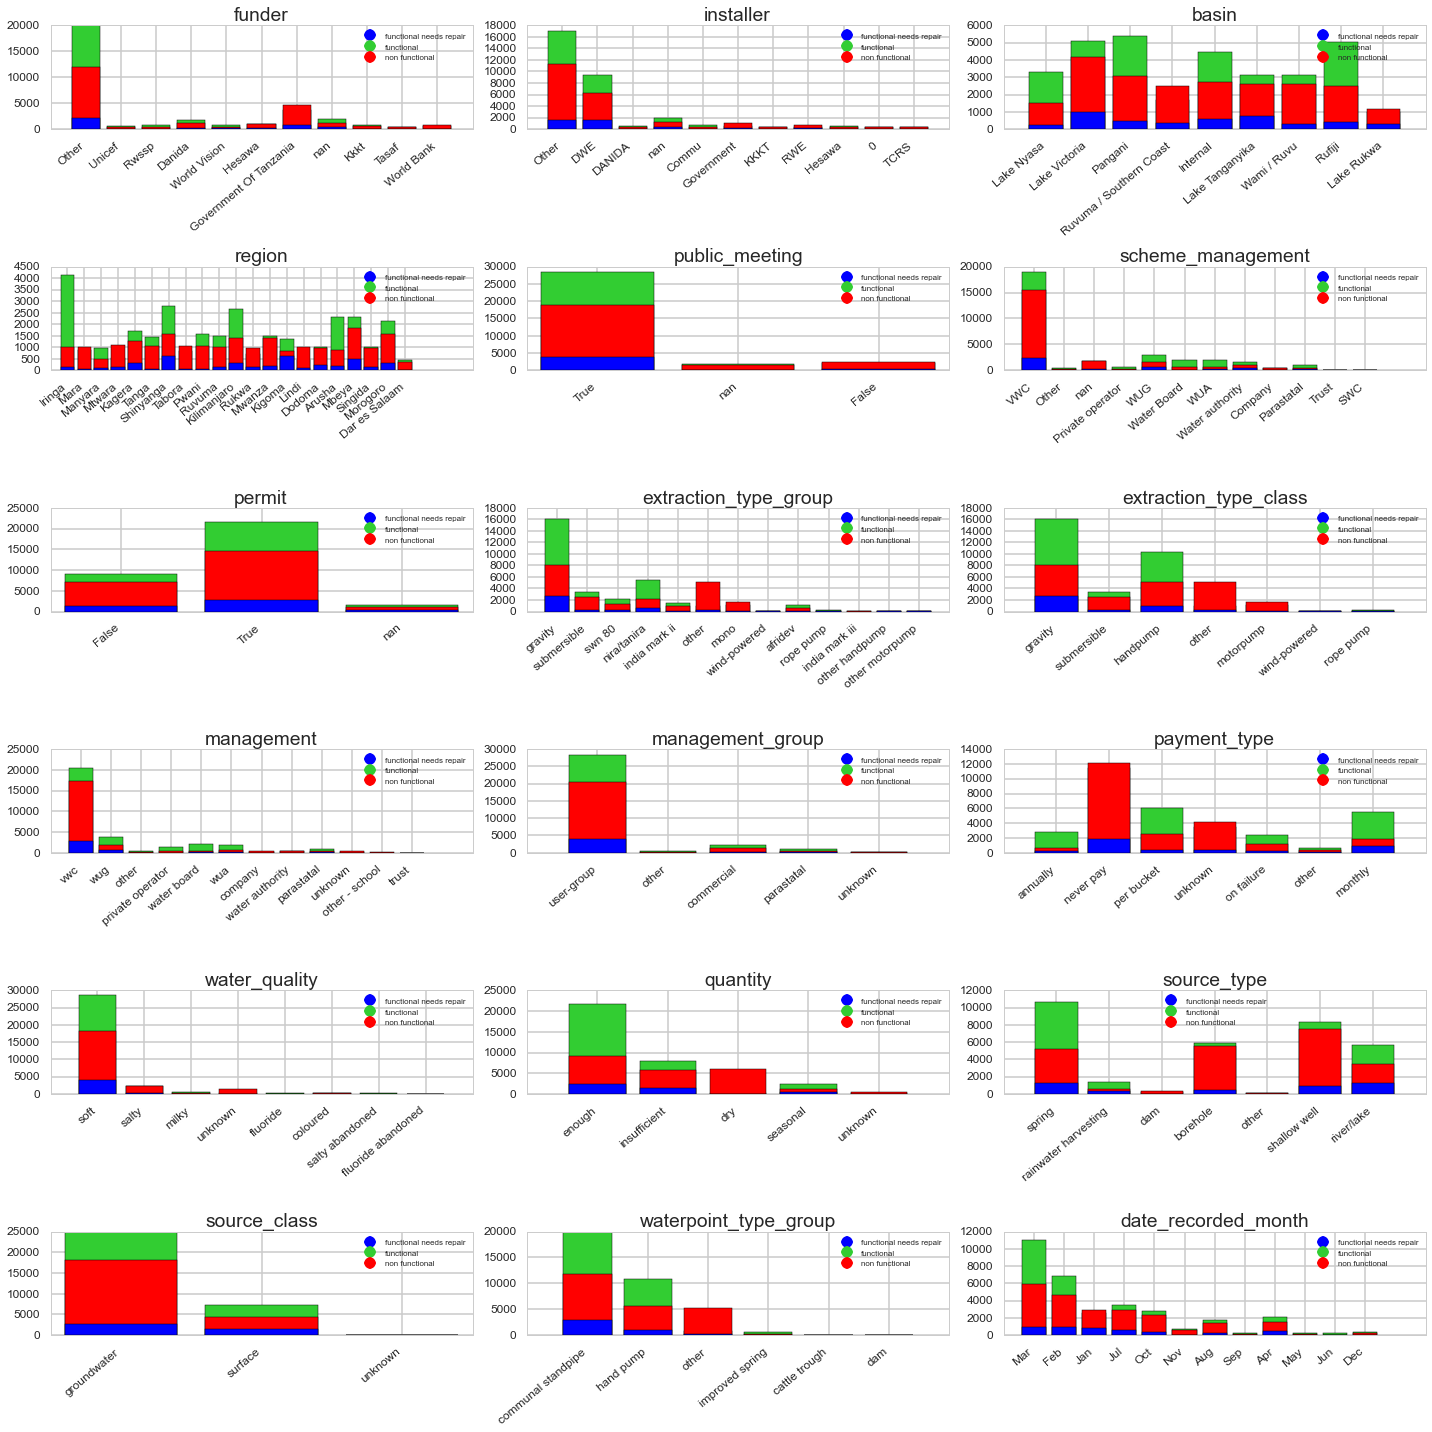

In [58]:
fig1, axes1 = plt.subplots(6,3,tight_layout=True,figsize=(20,20))

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
for j, variable in enumerate(CATEGORICAL):
    ax1 = axes1[j/3,j%3]
    functional = df_new[df_new['status_group']=='functional'][variable].tolist()
    non_functional = df_new[df_new['status_group']=='non functional'][variable].tolist()
    needs_repair = df_new[df_new['status_group']=='functional needs repair'][variable].tolist()
    categories = pd.Series(df_new[variable].values.ravel()).unique()
    value_freq_funct = []
    value_freq_nonf = []
    value_freq_repair = []
    categories_num = range(1,len(categories)+1)
    for value in categories:
        value_freq_funct.append(functional.count(value))
        value_freq_nonf.append(non_functional.count(value))
        value_freq_repair.append(needs_repair.count(value))
    ax1.bar(categories_num,value_freq_funct,align='center',color='limegreen')
    ax1.bar(categories_num,value_freq_nonf,align='center',color='r')
    ax1.bar(categories_num,value_freq_repair,align='center',color='b')
    ax1.set_xticks(categories_num)
    ax1.set_xticklabels(categories,ha='right',rotation=40)
    ax1.legend(markers,use_colors.keys(),loc='best',fontsize='8')
    ax1.set_title(variable)

plt.show()

#### Observations

From our precursory exploration of both the quantitative variables, we make a few observations:

- Functional wells tend to have much more total static head (the water available to the water point).
- The distribution of GPS height is bimodal across all well statuses.
- Larger populations are correlated with a higher probability of functionality; 
- The amount of time since recording also appears bimodal. This suggests that the reporting happened in approximately two waves.

Likewise, from our categorical variables, we note the following:

- Almost all wells funded by the Government of Tanzania were nonfunctional or needed repair at the time of reporting.
- Iringa, Arusha, and Kilimanjaro have a higher proportion of functional wells.
- The extraction type group and extraction type class might be very predictive because we see varying proportions of functionality across groups. For example, for extraction tyupe class gravity and handpump have a much higher proportion of functional well, as opposed to submersible and other types.
- Groundwater has a greater proportion of nonfunctional wells. 
- Dry wells are almost always nonfunctional.

In [92]:
pd.Series(df.funder.values.ravel()).unique()

array(['Other', 'Unicef', 'Rwssp', 'Danida', 'World Vision', 'Hesawa',
       'Government Of Tanzania', nan, 'Kkkt', 'Tasaf', 'World Bank'], dtype=object)

Recall that we found 19 categorical features in this data set. While we could encode these variables as ordinal numbers, our classifying algorithms expect a continuous input. Therefore, we turn to one-of-K, or one-hot, encoding to transform each categorical feature with $m$ possible values into $m$ binary features, of which only one is active.

In [16]:
#df_formatted includes all the data from df_new, with the categorical variables as indicators
df_formatted = pd.get_dummies(df_new, columns=CATEGORICAL)
df_formatted.head()

,amount_tsh,gps_height,population,date_recorded_offset_days,status_group,funder_Danida,funder_Government Of Tanzania,funder_Hesawa,funder_Kkkt,funder_Other,...,date_recorded_month_Dec,date_recorded_month_Feb,date_recorded_month_Jan,date_recorded_month_Jul,date_recorded_month_Jun,date_recorded_month_Mar,date_recorded_month_May,date_recorded_month_Nov,date_recorded_month_Oct,date_recorded_month_Sep
0,1.863770,1.045159,-0.155695,1.144795,functional,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,-0.102736,1.058167,0.212111,-1.018569,functional,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,-0.094542,0.027690,0.147584,-0.991639,functional,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,-0.102736,-0.583660,-0.265392,-0.907857,non functional,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-0.102736,-0.963765,-0.390145,0.782739,functional,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [17]:
#list of entire feature set
lcols = list(df_formatted.columns)
lcols.remove(u'status_group')
print len(lcols)

154


In [20]:
#split into test and training set
feat_matrix = df_formatted[lcols].values
lab_resp = df_formatted['status_group'].values

feat_train = feat_matrix[mask]
feat_test = feat_matrix[~mask]
lab_train = lab_resp[mask]
lab_test = lab_resp[~mask]

In [21]:
print feat_train.shape
print lab_train.shape

(41580, 154)
(41580,)


###  Exploration of Features and Preparation for Feature-Selection

Here, we simply take the Pearson Correlation Coefficients between each of the quantitative variables and the labels. We then sort to see a list of the most correlated or anti-correlated features, which we later use in our feature-selection process.

In [23]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [26]:
from scipy.stats.stats import pearsonr

Since we are correlating the features with the labels, and we have three labels, we convert the labels into values between 0 and 1. We chose to let 0 represent non functional, 0.5 represent functional needs repair, and 1 represent functional. However, note that had chosen a different scaling with the same order of features, we would have arrived with the same ranking of correlations.

We set a dictionary with these values, and then we create a new dataframe df_lab_change where the label has been changed into 0, 0.5, or 1.

In [24]:
status_dict = {'non functional': 0, 'functional needs repair': 0.5, 'functional': 1}

In [25]:
df_lab_change = df_formatted.replace({'status_group': status_dict})

In [27]:
# get correlation coefficients
correlations=[]
dftousetrain=df_formatted[mask]
lab_compare=df_formatted[mask].replace({'status_group': status_dict}, inplace=False)['status_group']
for col in lcols:
    r=pearsonr(dftousetrain[col], lab_compare)[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

In [44]:
# sort correlations and view top 25 
bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)

bpdf.head(15)

,abscorr,corr
feature,,
quantity_dry,0.397902,-0.397902
waterpoint_type_group_other,0.305812,-0.305812
extraction_type_group_other,0.291573,-0.291573
extraction_type_class_other,0.291573,-0.291573
quantity_enough,0.257664,0.257664
payment_type_never pay,0.172033,-0.172033
water_quality_unknown,0.161900,-0.161900
region_Iringa,0.141506,0.141506
extraction_type_group_gravity,0.131927,0.131927


We output this table into a CSV, which we now load to better visualize.

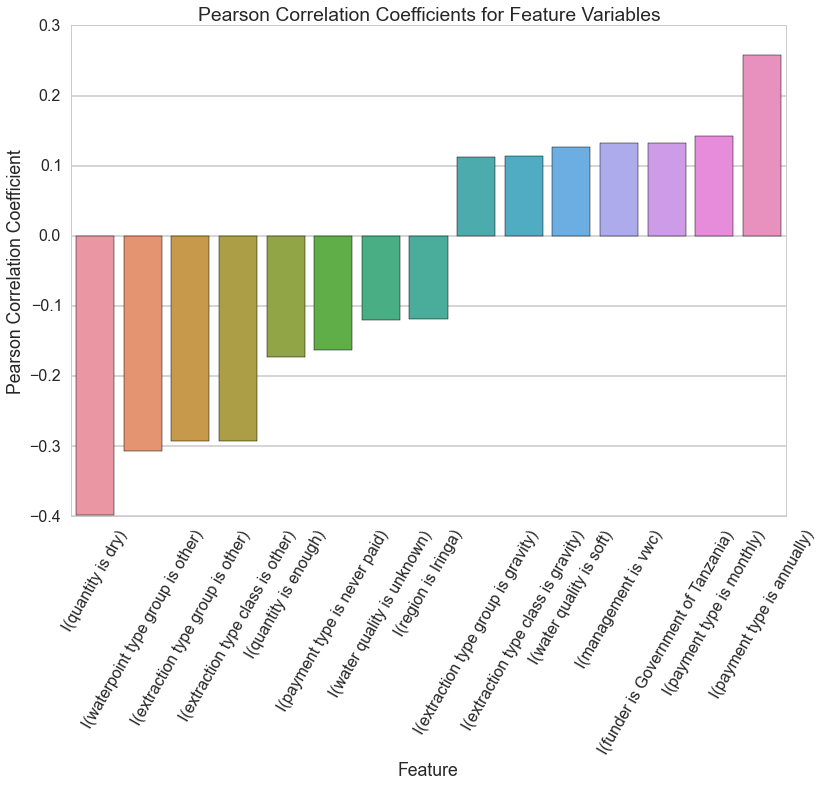

In [124]:
df_pearson = pd.read_csv('pearson_chart.csv')

x=sns.barplot('Feature','Pearson Correlation', data=df_pearson.sort('Pearson Correlation'))
x.set_ylabel("Pearson Correlation Coefficient")
x.set_xticklabels(df_pearson['Feature'],rotation=60)
x.set_title("Pearson Correlation Coefficients for Feature Variables")

In [29]:
# place the most correlated/anti-correlated in a new list for later reference
newlcols = list(bpdf.head(50).index.get_values())

print newlcols

[u'quantity_dry', u'waterpoint_type_group_other', u'extraction_type_group_other', u'extraction_type_class_other', u'quantity_enough', u'payment_type_never pay', u'water_quality_unknown', u'region_Iringa', u'extraction_type_group_gravity', u'extraction_type_class_gravity', u'water_quality_soft', u'management_vwc', u'funder_Government Of Tanzania', u'payment_type_monthly', u'payment_type_annually', 'gps_height', u'extraction_type_class_handpump', u'payment_type_per bucket', u'source_type_spring', u'extraction_type_group_nira/tanira', u'basin_Ruvuma / Southern Coast', u'payment_type_unknown', u'management_water board', u'waterpoint_type_group_hand pump', u'region_Mtwara', u'funder_Other', u'waterpoint_type_group_communal standpipe', u'extraction_type_class_motorpump', u'scheme_management_Water Board', u'extraction_type_group_mono', u'scheme_management_VWC', u'region_Lindi', u'date_recorded_month_Mar', u'installer_Government', u'installer_RWE', u'date_recorded_month_Jan', u'scheme_manageme

From a rudimentary interpretation of the pearson rho correlation coefficients, we suspect that quantity, wterpoint type, and extraction type will be the most critical to us. As we noted earlier, this makes sense, as having a dry quantity of water might prevent a well from working, while having enough might be more correlated with a working well. Moreover, we notice that there seems to be an association with "other" waterpoint and extraction types with a nonfunctional well. Interestingly, Iringa catches our attention as having a positive association with functional wells, whereas none of the other geographic areas show up in our list.

Overall, though, note that the magnitude of any of the correlation coefficients are never above 0.3-0.4. As we might expect from a real-world problem, there is clearly not one indicator or feature that predicts well funcionality, though these ones might be some of the more important ones to consider.

As we observed a short while ago, Iringa seems to do much better than other geographic areas. At this time, let's take a closer look at its map and well status.

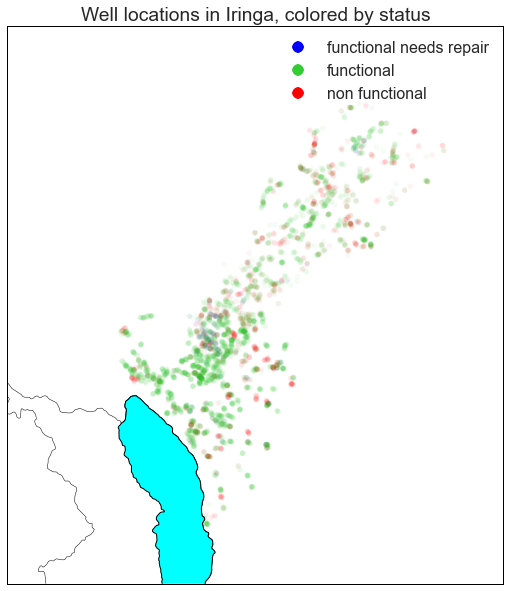

In [59]:
fig,ax1 = plt.subplots(1, figsize=(10,10))
mapwell(df[df.region == 'Iringa'],df[df.region.values == 'Iringa'].status_group, use_colors, ax=ax1, llcrnrlon=33, llcrnrlat=-11,
                urcrnrlon=37, urcrnrlat=-6.5)
ax1.legend(markers, use_colors.keys(), numpoints=1,loc='best')
ax1.set_title("Well locations in Iringa, colored by status")

Iringa's wells appear to have a higher association with functionality closer to the body of water. While we do not include a feature that clearly represents proximity to a body of water, perhaps this could be a latent feature in some of our current features, such as quantity. It certainly could be an interesting feature to explore in future models.

Let's also take a look at each of Iringa's other features individually below.

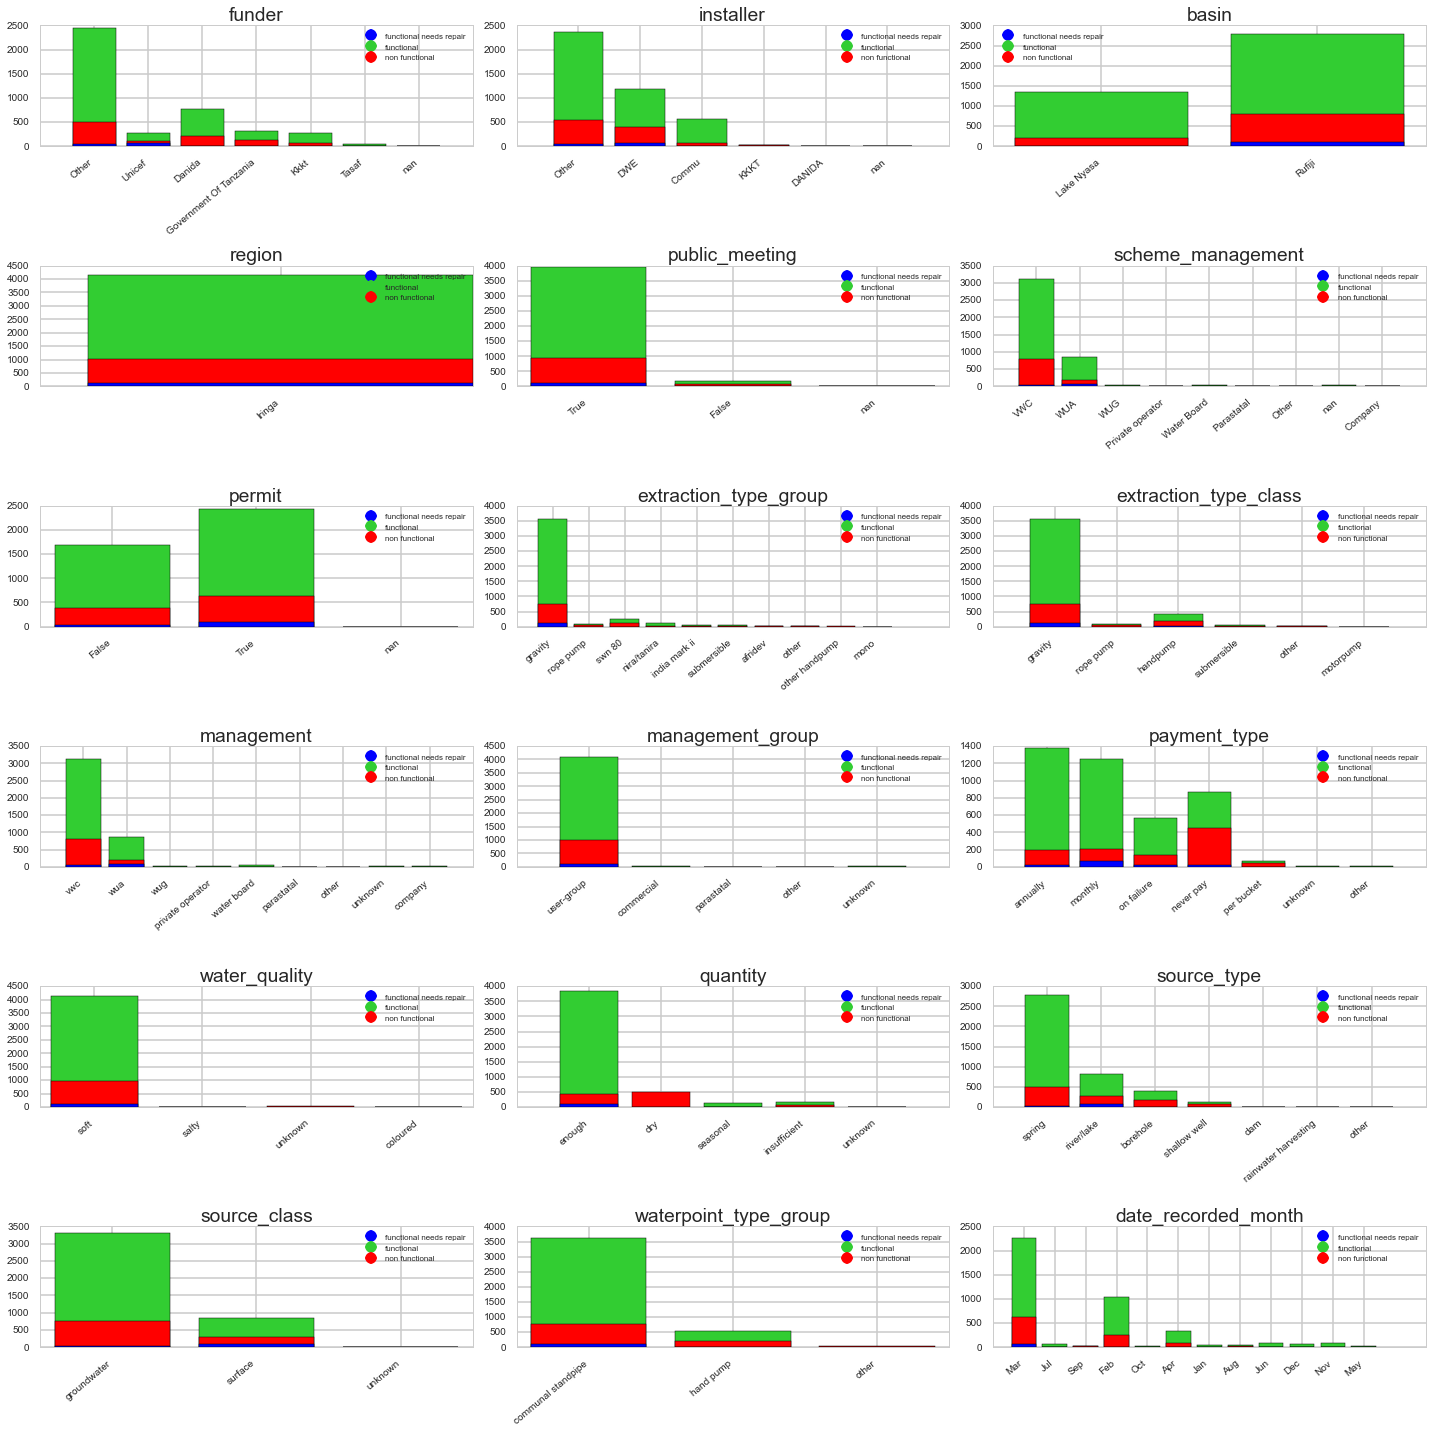

In [60]:
fig1, axes1 = plt.subplots(6,3,tight_layout=True,figsize=(20,20))

df_ir = df_new[df_new['region']=='Iringa']

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
for j, variable in enumerate(CATEGORICAL):
    ax1 = axes1[j/3,j%3]
    functional = df_ir[df_ir['status_group']=='functional'][variable].tolist()
    non_functional = df_ir[df_ir['status_group']=='non functional'][variable].tolist()
    needs_repair = df_ir[df_ir['status_group']=='functional needs repair'][variable].tolist()
    categories = pd.Series(df_ir[variable].values.ravel()).unique()
    value_freq_funct = []
    value_freq_nonf = []
    value_freq_repair = []
    categories_num = range(1,len(categories)+1)
    for value in categories:
        value_freq_funct.append(functional.count(value))
        value_freq_nonf.append(non_functional.count(value))
        value_freq_repair.append(needs_repair.count(value))
    ax1.bar(categories_num,value_freq_funct,align='center',color='limegreen')
    ax1.bar(categories_num,value_freq_nonf,align='center',color='r')
    ax1.bar(categories_num,value_freq_repair,align='center',color='b')
    ax1.set_xticks(categories_num)
    ax1.set_xticklabels(categories,ha='right',rotation=40)
    ax1.legend(markers,use_colors.keys(),loc='best',fontsize='8')
    ax1.set_title(variable)

plt.show()

We notice that there are certain characteristics which these Iringan wells seem to share in common:
- public meeting
- VWC scheme management
- salt water quality
- enough water (quantity)
- spring source type/groundwater source class
- communal standpipe waterpoint type group

# Models

Now that we've prepared our data and explored some of our features, let the analysis begin! We start with k-Nearest Neighbors as our baseline classifier.

## k-Nearest Neighbors (kNN)

In order to more clearly visualize a kNN algorithm, we first classify in a reduced feature space with two of the quantitative features. (In reality, we tested all combinations of the $\binom{4}{2}$ quantitative features and picked one of the more consistently accurate classifications.) 

Although the top two most correlated/anti-correlated are indicators and do not produce an interesting plot (only four points from 2x2 possibilities), we run the kNN algorithm on these top two as well to see how it does. We will later extend this in kNN classification with feature-selection for the top 50 most correlated/anti-correlated features. 

To optimize, we also classify and test with various values of k. 
For contrast's sake and an enhanced intuition, we classified and plotted with first 1 neighbor and then 50 neighbors.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

In [30]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [31]:
def classify(X,y, nbrs, result=True, plotit=False, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if result:
        print "Accuracy on training data: %0.2f" % (training_accuracy)
        print "Accuracy on test data:     %0.2f" % (test_accuracy)
    if plotit: 
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20)
    return nbrs, training_accuracy, test_accuracy

Accuracy on training data: 0.59
Accuracy on test data:     0.56


(1, 0.59396745230078563, 0.55677609427609431)

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


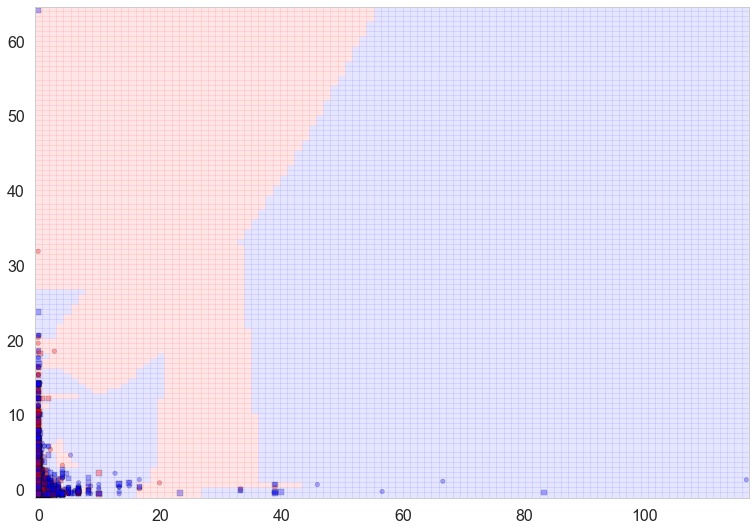

In [32]:
# select and plot two quantitative features
ys=df_lab_change['status_group'].astype(int).values
# subdf=df_lab_change[['amount_tsh','gps_height']]
subdf=df_lab_change[['amount_tsh','population']]
# subdf=df_lab_change[['amount_tsh','date_recorded_offset_days']]
# subdf=df_lab_change[['gps_height', 'population']]
# subdf=df_lab_change[['gps_height', 'date_recorded_offset_days']]
# subdf=df_lab_change[['population','date_recorded_offset_days']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs2quant=subdfstd.values

classify(Xs2quant,ys,1,plotit=True)

Accuracy on training data: 0.60
Accuracy on test data:     0.59


(50, 0.59870931537598204, 0.58851010101010104)

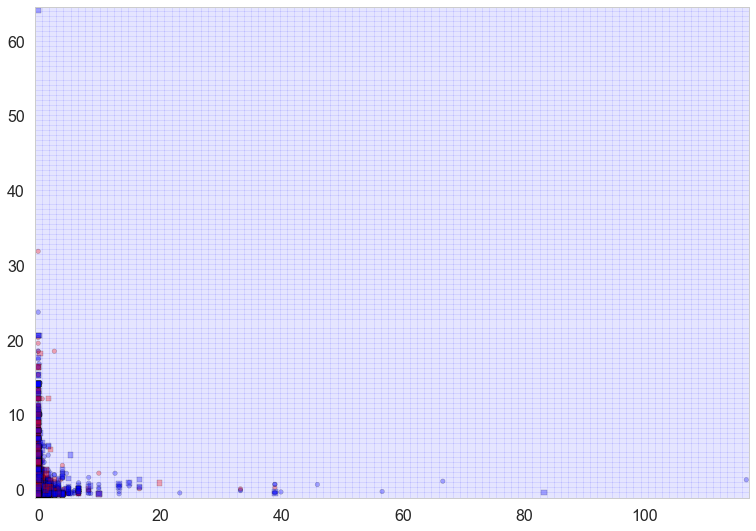

In [34]:
# classify for the same two quantitative features on k=50
classify(Xs2quant,ys,50,result=True,plotit=True)

From classifying on two of the quantitative features, we find that we do not do as well, regardless of whether we classified with k=1 or k=50. Accuracy on both training and test set remained around 60%. The plot reflects this result, as we see that the red and blue points, representing the two quantitative variables, are both clustered on the lower end and do not classify accurately here. Further out, the points are so spread out that we are skeptical of the true accuracy of the classification, especially for larger k such as in with k=50.

[u'quantity_dry', u'waterpoint_type_group_other']
Accuracy on training data: 0.70
Accuracy on test data:     0.70


(1, 0.69767115600448937, 0.70067340067340067)

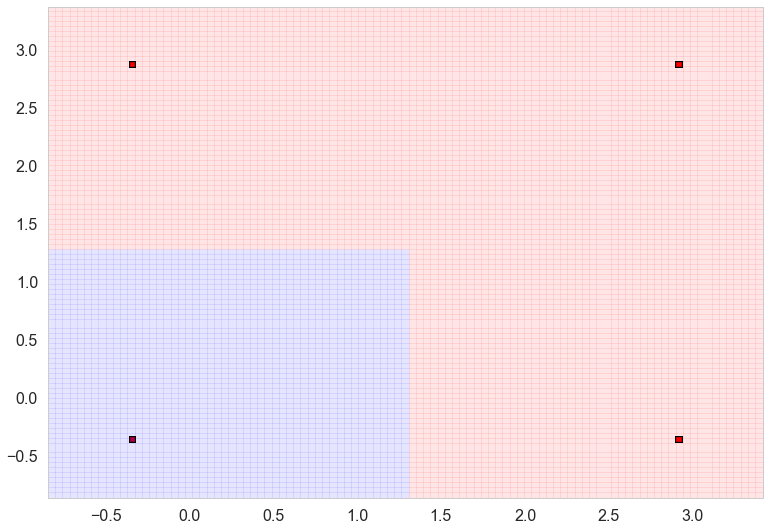

In [33]:
# select two features using largest abs(correlation coefficient)
twofeats=list(bpdf.head(2).index.get_values())
print twofeats

# classify on these two most correlated/anticorrelated features
ys=df_lab_change['status_group'].astype(int).values
subdf=df_lab_change[twofeats]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs2=subdfstd.values

classify(Xs2,ys,1,plotit=True)

With more careful feature selection for the two most correlated/anti-correlated features, we find much better accuracy. However, as we realized earlier, with only two possibilities per feature for a total of four points, this plot is uninteresting and simply tells us that we would do significantly better by about 10% if we simply classified based on whether the quantity is "dry" and the waterpoint group is "other." This begs the question of what it might be about this "other" waterpoint group--we investigate this further in visualization of a clearer breakdown for waterpoint group. 

We hope to do better than 70% accuracy, though, so we plot (though not literally this time) forward with a larger, but still selective, feature-set. We now turn to the newlcols we created before and test on k=1 and k=50. Now, however, as we have more than two dimensions of features, a plot becomes more difficult to visualize, so we exclude it.

In [35]:
# classify on the 50 most correlated/anticorrelated features, from the newlcols list before
ys=df_lab_change['status_group'].astype(int).values
subdf=df_lab_change[newlcols]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs50=subdfstd.values

classify(Xs50,ys,1,result=True,plotit=False)

Accuracy on training data: 0.91
Accuracy on test data:     0.75


(1, 0.91024130190796859, 0.74638047138047137)

In [37]:
# and again for k=50 (still using 50 features)
classify(Xs50,ys,50,result=True,plotit=False)

Accuracy on training data: 0.76
Accuracy on test data:     0.76


(50, 0.76290684624017957, 0.75896464646464645)

A larger feature-set seems to have improved the accuracy, although the number of nearest neighbors didn't make much of a difference. As we might expect for k=1, we overfit on the training data such that it is less accurate on the test data. We try to decrease this overfitting by increasing k to 50, which gave us less overfitting and a marginally better accuracy. 

Finally, as a separate baseline of sorts, we try using the full feature-set.

In [38]:
# use all features
ys=df_lab_change['status_group'].astype(int).values
subdf=df_lab_change.drop('status_group', axis=1)
subdfstd=(subdf - subdf.mean())/subdf.std()
allXs=subdfstd.values

In [39]:
classify(allXs,ys,1,result=True,plotit=False)

Accuracy on training data: 0.97
Accuracy on test data:     0.77


(1, 0.96731200897867564, 0.76666666666666672)

In [40]:
classify(allXs,ys,50,result=True,plotit=False)

Accuracy on training data: 0.75
Accuracy on test data:     0.74


(50, 0.75101010101010102, 0.73682659932659933)

The full-feature set seems not to have done much better than the feature-selected set. Again, we observe that a k=1 creates overfitting issues, which k=50 diminishes. The accuracy remains roughly around 75%. Let's see if we can do better with varying values of k.

We proceed with the feature-selected set. We wish to increase our prediction ability by playing around with various values of k. In order to do this, we write two functions to help us explore the best parameters: cv_optimize() and do_classify().

In [96]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [94]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname].values
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [94]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname].values
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

Above, we use the score() function in to measure the accuracy of our model's predictions. Other model evaluation/comparison measures we could consider are the balanced F-score (sklearn.metrics.f1_score()), the Kappa Statistic, Confusion Matrix, Hamming Loss, and Zero One loss. More options can be found here: http://scikit-learn.org/stable/modules/model_evaluation.html.

In [49]:
%%time
knn, __, __, __, __ = do_classify(KNeighborsClassifier(), {"n_neighbors": [5, 10, 15, 20, 25, 30, 35, 40, 45]}, df_formatted, newlcols, 'status_group', 1, mask=mask)

using mask
BEST {'n_neighbors': 5} 0.748412698413 [mean: 0.74841, std: 0.00282, params: {'n_neighbors': 5}, mean: 0.74759, std: 0.00456, params: {'n_neighbors': 10}, mean: 0.74598, std: 0.00309, params: {'n_neighbors': 15}, mean: 0.74149, std: 0.00328, params: {'n_neighbors': 20}, mean: 0.74120, std: 0.00186, params: {'n_neighbors': 25}, mean: 0.73742, std: 0.00245, params: {'n_neighbors': 30}, mean: 0.73499, std: 0.00238, params: {'n_neighbors': 35}, mean: 0.73389, std: 0.00351, params: {'n_neighbors': 40}, mean: 0.73201, std: 0.00369, params: {'n_neighbors': 45}]
############# based on standard predict ################
Accuracy on training data: 0.81
Accuracy on test data:     0.76
[[8413  255 1000]
 [ 773  299  226]
 [1854  154 4846]]
########################################################
CPU times: user 17min 7s, sys: 9.26 s, total: 17min 17s
Wall time: 17min 43s


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In this instance, k=5 appears to have produced the best results.

Even so, we still don't seem to have improved much from an accuracy of 75%. Let's move on to a different classification algorithm and see if we can improve--we now turn to the Naive Bayes classifier.

##  Naive Bayes

Because we have a combination of categorical and continuous predictors, we first independently fit a Gaussian Naive Bayes model on the continuous data and a bernoulli Naive Bayes model on the categorical part. 

While the probabilities may not be too well calibrated, the relative order of of the probabilities across the labels is typically correct.

In [65]:
# Even though we already split into training/test set above, feat_train and feat_test are matrices
# Below, to separate categorical and continuous, we wish to use them as dataframes.

#feat_train and lab_train analogous to Xtrain and ytrain
feat_train_df = df_formatted[mask].drop('status_group',axis=1)
lab_train_df = pd.DataFrame(df_formatted[mask].status_group)
#feat_test and lab_test analogous to Xtrain and ytrain
feat_test_df = df_formatted[~mask].drop('status_group',axis=1)
lab_test_df = pd.DataFrame(df_formatted[~mask].status_group)

In [63]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

#separate categorical and continuous
cont_feat_train = feat_train_df[STANDARDIZABLE].values
cat_feat_train = feat_train_df.drop(STANDARDIZABLE,axis=1).values
cont_feat_test = feat_test_df[STANDARDIZABLE].values
cat_feat_test = feat_test_df.drop(STANDARDIZABLE,axis=1).values

In [66]:
#fit the continuous variables to a Gaussian Naive Bayes
gnb_clf = GaussianNB()
gnb_clf.fit(cont_feat_train, lab_train_df)
print "Frac of correctly labeled points",float((lab_test_df.values.transpose().tolist() == gnb_clf.predict(cont_feat_test)).sum())/lab_test_df.shape[0]
confusion_matrix(gnb_clf.predict(cont_feat_test),lab_test_df)

Frac of correctly labeled points 0.418013468013


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 836,   57,  241],
       [   0,    0,    0],
       [8832, 1241, 6613]])

In [68]:
#fit the categorical variables to a Bernoulli Naive Bayes
bnb_clf = BernoulliNB()
bnb_clf.fit(cat_feat_train, lab_train_df)

print "Frac of correctly labeled points",float((lab_test_df.values.transpose().tolist() == bnb_clf.predict(cat_feat_test)).sum())/lab_test_df.shape[0]
confusion_matrix(bnb_clf.predict(cat_feat_test),lab_test_df)

 Frac of correctly labeled points 0.659708193042


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[7081,  589, 2017],
       [ 994,  461,  623],
       [1593,  248, 4214]])

We have a higher accuracy, yet we can still do better. We know that the Bernoulli model factors into account the nonoccurence of the different features. As a result, it puts more weight on the features that have many values associated, not factoring in inherent dependence and mutually exclusive nature of these feature. For example, if a row has a 1 for funder World Bank, it will have a 0 for all the other funders, and the Bernoulli model will take into account the 1 and all the 0s, despite them being very dependent.

We instead fit the model for categorical feature variables to a Multinomial Naive Bayes. The model performs better, as shown below.

In [69]:
#fit the categorical variables to a Multinomial Naive Bayes
mnb_clf = MultinomialNB()
mnb_clf.fit(cat_feat_train, lab_train_df)

print "Frac of correctly labeled points",float((lab_test_df.values.transpose().tolist() == mnb_clf.predict(cat_feat_test)).sum())/lab_test_df.shape[0]
confusion_matrix(mnb_clf.predict(cat_feat_test),lab_test_df)

Frac of correctly labeled points 0.680864197531


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[7605,  687, 2334],
       [ 705,  383,  375],
       [1358,  228, 4145]])

Naive Bayes does not work well with highly correlated features because the conditional independence assumption of Naive Bayes overinflates the importance of these correlated features by effectively counting them twice. Thus, we remove some of the redundant features, particularly the more broad feature in the nesting structures.

In [70]:
small_df_new = df_new.drop(['management_group','source_class','extraction_type_class'], axis=1)
small_df_formatted = pd.get_dummies(small_df_new, columns=list(set(CATEGORICAL).difference(['management_group','source_class','extraction_type_class'])))

reduced_feat_train = small_df_formatted[mask].drop('status_group',axis=1)
reduced_feat_test = small_df_formatted[~mask].drop('status_group',axis=1)

cont_feat_train1 = reduced_feat_train[STANDARDIZABLE].values
cat_feat_train1 = reduced_feat_train.drop(STANDARDIZABLE,axis=1).values
cont_feat_test1 = reduced_feat_test[STANDARDIZABLE].values
cat_feat_test1 = reduced_feat_test.drop(STANDARDIZABLE,axis=1).values

In [72]:
gnb_clf1 = GaussianNB()
gnb_clf1.fit(cont_feat_train1, lab_train)
print "Frac of correctly labeled points",float((lab_test_df.values.transpose().tolist() == gnb_clf1.predict(cont_feat_test1)).sum())/lab_test_df.shape[0]
confusion_matrix(gnb_clf1.predict(cont_feat_test1),lab_test_df)

 Frac of correctly labeled points 0.418013468013


array([[ 836,   57,  241],
       [   0,    0,    0],
       [8832, 1241, 6613]])

In [73]:
#fit the categorical variables to a Bernoulli Naive Bayes
bnb_clf1 = BernoulliNB()
bnb_clf1.fit(cat_feat_train1, lab_train_df)

print "Frac of correctly labeled points",float((lab_test_df.values.transpose().tolist() == bnb_clf1.predict(cat_feat_test1)).sum())/lab_test_df.shape[0]
confusion_matrix(bnb_clf1.predict(cat_feat_test1),lab_test_df)

Frac of correctly labeled points 0.675982042649


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[7251,  609, 2085],
       [ 710,  408,  382],
       [1707,  281, 4387]])

Since we split the categorical and quantitative features, we did not get to use all our features. To allow for that, we bucket our quantitative features to turn them into categorical ones. We bucket them how we deem appropriate according to the graphs above.

In [74]:
#turn quantitative variables to categorical ones
df_allcat = small_df_new.copy()

df_allcat.ix[df_allcat.amount_tsh>40, 'amount_tsh'] = "High"
df_allcat.ix[(df_allcat.amount_tsh>10) & (df_new.amount_tsh<=40), 'amount_tsh'] = "Medium"
df_allcat.ix[df_allcat.amount_tsh<=10, 'amount_tsh'] = "Low"

df_allcat.ix[df_allcat.gps_height>0, 'gps_height'] = "Above avg"
df_allcat.ix[df_allcat.gps_height<=0, 'gps_height'] = "Below avg"

df_allcat.ix[df_allcat.date_recorded_offset_days>0, 'date_recorded_offset_days'] = "Above avg"
df_allcat.ix[df_allcat.date_recorded_offset_days<=0, 'date_recorded_offset_days'] = "Below avg"

df_allcat.ix[df_allcat.population>10, 'population'] = "High"
df_allcat.ix[(df_allcat.population<10)&(df_allcat.population>0), 'population'] = "Medium"
df_allcat.ix[df_allcat.population<=0, 'population'] = "Low"

In [75]:
df_allcat = df_allcat.drop('status_group',axis=1)
df_allcat_formatted = pd.get_dummies(df_allcat)

new_feat_train = df_allcat_formatted[mask]
new_feat_test = df_allcat_formatted[~mask]

In [76]:
#fit all variables to a Bernoulli Naive Bayes
bnb_clf2 = BernoulliNB()
bnb_clf2.fit(new_feat_train, lab_train_df)

print "Frac of correctly labeled points",float((lab_test_df.values.transpose().tolist() == bnb_clf2.predict(new_feat_test)).sum())/lab_test_df.shape[0]
confusion_matrix(bnb_clf2.predict(new_feat_test),lab_test_df)

Frac of correctly labeled points 0.66835016835


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[7093,  587, 2077],
       [ 739,  427,  387],
       [1836,  284, 4390]])

As we can see, the Naive Bayes classifier doesn't even perform as well as kNN; it's more of our baseline classifier in terms of lowest accuracy after some optimization. 

At this point, rather than continuing to attempt optimizing our Naive Bayes classifier, since mixing the Gaussian and Bernoulli Naive Bayes models is rather difficult, we move to a model that can more easily include both: the SVM.

##  SVM

Bearing in mind that we have a large sample size, we begin SVM classification by implementing a linear SVM, explicitly passing in the standard SVM hinge loss. We choose to begin here as the kernalized SVM training time that we will attempt later scales with the sample size, and we want to quickly classify on all features as a baseline. 

In our optimization process, we will toy around with loss function, feature-selection, and label balancing, before moving on to kernalized SVMs.

In [77]:
from sklearn.svm import LinearSVC

Recalling that we conveniently created the do_classify function earlier to optimize over the hyperparameters, we run a first test on all labels and all features.

In [78]:
%%time
clfsvm1, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted, lcols, 'status_group', 1, mask=mask)

using mask
BEST {'C': 0.01} 0.716738816739 [mean: 0.69788, std: 0.00427, params: {'C': 0.001}, mean: 0.71674, std: 0.00585, params: {'C': 0.01}, mean: 0.71219, std: 0.00608, params: {'C': 0.1}, mean: 0.71044, std: 0.00622, params: {'C': 1.0}, mean: 0.71534, std: 0.00854, params: {'C': 10.0}, mean: 0.64901, std: 0.02836, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.72
Accuracy on test data:     0.72
[[9129    0  539]
 [1136    0  162]
 [3081    0 3773]]
########################################################
CPU times: user 7min 42s, sys: 5.81 s, total: 7min 48s
Wall time: 17min 51s


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Even a first run without much optimization for SVM is performing better than the Naive Bayes classifier. It's not quite the same 

First, though, let's keep track of this split so that we can compare with future optimizations.

In [79]:
# for purposes of comparison with SVM optimization later
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

### SVM Optimized for Feature Selection

With the number of features that we have and the related indicator variables, there is almost certainly a strong correlation between features. Therefore, we are subject to the curse of dimensionality and may wish to more carefully select our features. 

Earlier, we took the pearson correlation coefficients of each of our features; let's now use the list of 50 most correlated/anti-correlated features, stored in newlcols, and see how we do. 

In [80]:
%%time
clfsvm2, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted, newlcols, 'status_group',1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.01} 0.716738816739 [mean: 0.69788, std: 0.00427, params: {'C': 0.001}, mean: 0.71674, std: 0.00585, params: {'C': 0.01}, mean: 0.71195, std: 0.00631, params: {'C': 0.1}, mean: 0.71121, std: 0.00562, params: {'C': 1.0}, mean: 0.71556, std: 0.00822, params: {'C': 10.0}, mean: 0.64529, std: 0.04012, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.72
Accuracy on test data:     0.72
[[9129    0  539]
 [1137    0  161]
 [3081    0 3773]]
########################################################
CPU times: user 7min 27s, sys: 5.14 s, total: 7min 32s
Wall time: 7min 48s


How does a limited feature set compare to the full feature set? At least for the linear SVM, it appears to perform similarly. When we continue on to the next step then, we use this smaller feature-set. 

### SVM Optimized for Balancing

Why might balancing be necessary? We observe that in our full training data set, whereas 22,591 wells are function, only 15,970 are nonfunctional. More concerning, only 3,019 wells are of the "functional needs repair" status. Out of concern that this imbalance may affect how our model performs after training, we randomly balance the set such that there are equal numbers of wells with each status. 

From the previous step, we perform the SVM on the feature-selected set.

In [81]:
jtrain=np.arange(0, lab_train.shape[0])
func=len(jtrain[lab_train=='functional'])
repair=len(jtrain[lab_train=='functional needs repair'])
nonfunc=len(jtrain[lab_train=='non functional'])
print func, repair, nonfunc

22591 3019 15970


In [82]:
pick_func = np.random.choice(jtrain[lab_train=='functional'], repair, replace=False)
pick_nonfunc = np.random.choice(jtrain[lab_train=='non functional'], repair, replace=False)

In [83]:
indices = np.concatenate((pick_func, jtrain[lab_train=='functional needs repair'], pick_nonfunc))

In [84]:
feat_train_balanced = feat_train[indices]
lab_train_balanced = lab_train[indices]
print feat_train_balanced.shape, lab_train_balanced.shape

(9057, 154) (9057,)


In [85]:
# store a balanced split to use
reuse_split_balanced=dict(Xtrain=feat_train_balanced, Xtest=feat_test, ytrain=lab_train_balanced, ytest=lab_test)

In [88]:
%%time
# run linear SVM for balanced split (still with feature-selection)
clfsvm3, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted, newlcols, 'status_group', 1, reuse_split=reuse_split_balanced)

using reuse split
BEST {'C': 10.0} 0.612785690626 [mean: 0.58684, std: 0.01081, params: {'C': 0.001}, mean: 0.59611, std: 0.01189, params: {'C': 0.01}, mean: 0.60660, std: 0.01052, params: {'C': 0.1}, mean: 0.60870, std: 0.01167, params: {'C': 1.0}, mean: 0.61279, std: 0.01315, params: {'C': 10.0}, mean: 0.49619, std: 0.03240, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.62
Accuracy on test data:     0.59
[[6256 2843  569]
 [ 299  911   88]
 [1885 1536 3433]]
########################################################
CPU times: user 51.2 s, sys: 651 ms, total: 51.8 s
Wall time: 53.4 s


As we might expect from limiting the number of sets to train on greatly, we now have less information to train on, and thus, lower accuracy. With this insight, we give up on balancing for future optimization attempts. 

### SVM Optimized for Loss Function

As one last optimization attempt for linear SVM, let's also try moving away from the standard hinge loss function, to give a shot at linear SVM using the hinge$^2$ loss function.

In [125]:
%%time
# run linear SVM for balanced split (still with feature-selection), but with hinge^2
clfsvm4, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="squared_hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted, newlcols, 'status_group', 1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.01} 0.729966329966 [mean: 0.72525, std: 0.00659, params: {'C': 0.001}, mean: 0.72997, std: 0.00667, params: {'C': 0.01}, mean: 0.72917, std: 0.00642, params: {'C': 0.1}, mean: 0.72946, std: 0.00609, params: {'C': 1.0}, mean: 0.72973, std: 0.00679, params: {'C': 10.0}, mean: 0.65082, std: 0.05042, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.73
[[8784    1  883]
 [1061    3  234]
 [2550    0 4304]]
########################################################
CPU times: user 11min 31s, sys: 6.17 s, total: 11min 37s
Wall time: 31min 21s


Given these results using the same split and feature-set, with the only difference being the loss function, we see that while hinge$^2$ marginally improves the accuracy, we do not do significantly better. Let's try a different type of SVM, which instead of using a linear function, uses the idea of clusters. RBF is more likely to give a better accuracy, although it takes longer, which is why we started with the linear SVM.

## Radial Basis Function (RBF) Kernalized SVM
Instead, rather than continue attempting optimizations for a linear SVM, let's try classifying using an SVM based on Radial Basis Function (RBF) Kernels. While we will see shortly that not constricting ourselves to a linear function improves upon our classification accuracy, our SVM now takes significantly longer. We'll want to strategize by using our do_classify() and cv_optimize() function to first pick the best $C$ and $\gamma$ hyperparameters before continuing.

Note: In actuality, we optimize over the hyperparameters for a range of $C$ and $\gamma$. However, as each took an incredibly long time to output, we only include the optimized hyperparameters here in this finalized process notebook. Ideally, with more powerful processors and more time, we would want to test out more hyperparameter optimizations.

In [89]:
from sklearn.svm import SVC

In [126]:
%%time
# run RBF kernel on the entire data set (not balanced) and with feature-selection
# use cv_optimize to optimize hyperparameters
kernsvm1, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), {"C": [1e2],"gamma":[1e-2]}, df_formatted, newlcols, 'status_group', 1, reuse_split=reuse_split)

using reuse split
BEST {'C': 100.0, 'gamma': 0.01} 0.778667628668 [mean: 0.77867, std: 0.00215, params: {'C': 100.0, 'gamma': 0.01}]
############# based on standard predict ################
Accuracy on training data: 0.81
Accuracy on test data:     0.79
[[8771  129  768]
 [ 767  318  213]
 [1824   65 4965]]
########################################################
CPU times: user 1h 16min 31s, sys: 22.1 s, total: 1h 16min 53s
Wall time: 1h 17min 27s


As we expected, we see improvement! The accuracy is now our current personal best, at closer to 80%.

We also try running the RBF kernel on the full feature-set.

Note: While we originally ran the following cell, in the interest of time for the finalization of this process notebook, we did not get a chance to run it again. (It takes several hours.) However, the results from the previous run did not give significantly better results and can be found on our website here under "SVM":
http://avisaraf.github.io/WellWatchers/

In [ ]:
# %%time
# # run RBF kernel on the entire data set (not balanced) with all features
# # use optimal parameters from before in the interest of time
# kernsvm2, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), {"C": [1e2],"gamma":[1e-2]}, df_formatted, lcols, 'status_group', 1, reuse_split=reuse_split)

In [ ]:
# %%time
# # Possibility for the future: Polynomial Kernel
# # Here, this code would run a polynomial kernel on the entire data set (not balanced) for the optimal parameters and entire feature set
# polysvm1, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(degree=3), {"C": [1e2],"gamma":[1e-2]}, df_formatted, newlcols, 'status_group', 1, reuse_split=reuse_split)

We still haven't improved substantially from the best of the kNN results. Let's try one last classifier before we move on to regression.

We decide to run a random forest, believing that this aggregate model could get us even higher prediction accuracies. We will optimize on the number of trees (n_estimators), the minimum number of samples required to split a node (min_samples_split, which also affects the max depth of the tree), and maximum number of features (max_features).

##  Random Forest

In Random Forest, we optimize for the number of trees to consider for the best split each time.

In [91]:
feat_cols=list(df_formatted.columns)
feat_cols.remove(u'status_group')

In [92]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

In [97]:
%%time
parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, df_formatted, feat_cols, 'status_group', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 19} 0.773461638328 [mean: 0.72608, std: 0.00467, params: {'n_estimators': 1}, mean: 0.73797, std: 0.00466, params: {'n_estimators': 2}, mean: 0.75427, std: 0.00365, params: {'n_estimators': 3}, mean: 0.75620, std: 0.00198, params: {'n_estimators': 4}, mean: 0.76048, std: 0.00277, params: {'n_estimators': 5}, mean: 0.76589, std: 0.00175, params: {'n_estimators': 6}, mean: 0.76476, std: 0.00163, params: {'n_estimators': 7}, mean: 0.76689, std: 0.00138, params: {'n_estimators': 8}, mean: 0.76914, std: 0.00264, params: {'n_estimators': 9}, mean: 0.76966, std: 0.00137, params: {'n_estimators': 10}, mean: 0.77089, std: 0.00142, params: {'n_estimators': 11}, mean: 0.76887, std: 0.00170, params: {'n_estimators': 12}, mean: 0.77180, std: 0.00262, params: {'n_estimators': 13}, mean: 0.77232, std: 0.00339, params: {'n_estimators': 14}, mean: 0.76973, std: 0.00161, params: {'n_estimators': 15}, mean: 0.77182, std: 0.00262, params: {'n_estimators': 16}, mean: 0.77195, std: 0.0

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of

In [99]:
# get number of trees (n_estimators)
len(clfForest.estimators_)

19

We see that this is at the maximum of our range. Thus, we increase the the range that we optimize over during our GridSearchCV.

In [100]:
%%time
parameters = {"n_estimators": range(18, 40)}
clfForest1, Xtrain, ytrain, Xtest, ytest = do_classify(RandomForestClassifier(), parameters, df_formatted, feat_cols, 'status_group', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 31} 0.775792138916 [mean: 0.77354, std: 0.00221, params: {'n_estimators': 18}, mean: 0.77296, std: 0.00161, params: {'n_estimators': 19}, mean: 0.77351, std: 0.00153, params: {'n_estimators': 20}, mean: 0.77293, std: 0.00202, params: {'n_estimators': 21}, mean: 0.77335, std: 0.00192, params: {'n_estimators': 22}, mean: 0.77362, std: 0.00168, params: {'n_estimators': 23}, mean: 0.77307, std: 0.00133, params: {'n_estimators': 24}, mean: 0.77485, std: 0.00250, params: {'n_estimators': 25}, mean: 0.77497, std: 0.00037, params: {'n_estimators': 26}, mean: 0.77333, std: 0.00213, params: {'n_estimators': 27}, mean: 0.77348, std: 0.00220, params: {'n_estimators': 28}, mean: 0.77355, std: 0.00192, params: {'n_estimators': 29}, mean: 0.77547, std: 0.00135, params: {'n_estimators': 30}, mean: 0.77579, std: 0.00119, params: {'n_estimators': 31}, mean: 0.77418, std: 0.00176, params: {'n_estimators': 32}, mean: 0.77413, std: 0.00099, params: {'n_estimators': 33}, mean: 0.77489,

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of

We check that we have not hit the boundary of the range we gave and indeed found an optimal value.

In [101]:
len(clfForest1.estimators_)

31

In the above classifier, we set the max_depth to None, meaning nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples (in this case, 2). We try limiting the max depth by increasing the min_samples_split size to see if this improves our performance, especially since it seems like the above classifier is overfitting to the training set. Thus we add min_sample_split to parameters to optimize.

In [102]:
%%time
parameters = {"n_estimators": range(18,40), "min_samples_split": range(2,10)}
clfForest2, Xtrain, ytrain, Xtest, ytest = do_classify(RandomForestClassifier(), parameters, df_formatted, feat_cols, 'status_group', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'min_samples_split': 6, 'n_estimators': 32} 0.782915488914 [mean: 0.77390, std: 0.00254, params: {'min_samples_split': 2, 'n_estimators': 18}, mean: 0.77116, std: 0.00301, params: {'min_samples_split': 2, 'n_estimators': 19}, mean: 0.77318, std: 0.00208, params: {'min_samples_split': 2, 'n_estimators': 20}, mean: 0.77297, std: 0.00154, params: {'min_samples_split': 2, 'n_estimators': 21}, mean: 0.77277, std: 0.00322, params: {'min_samples_split': 2, 'n_estimators': 22}, mean: 0.77418, std: 0.00196, params: {'min_samples_split': 2, 'n_estimators': 23}, mean: 0.77487, std: 0.00232, params: {'min_samples_split': 2, 'n_estimators': 24}, mean: 0.77410, std: 0.00271, params: {'min_samples_split': 2, 'n_estimators': 25}, mean: 0.77381, std: 0.00242, params: {'min_samples_split': 2, 'n_estimators': 26}, mean: 0.77413, std: 0.00152, params: {'min_samples_split': 2, 'n_estimators': 27}, mean: 0.77531, std: 0.00192, params: {'min_samples_split': 2, 'n_estimators': 28}, mean: 0.77598, std: 0

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of

In [103]:
clfForest2.n_estimators

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of

32

/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/cindyzhao0521/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of

In [104]:
clfForest2.min_samples_split

6

We also optimize for number of features.

In [105]:
num_feat = len(feat_cols)

In [118]:
%%time
parameters = {"n_estimators": [35], "min_samples_split": [7], 'max_features': range(2, num_feat)}
clfForest3, Xtrain, ytrain, Xtest, ytest = do_classify(RandomForestClassifier(), parameters, df_formatted, feat_cols, 'status_group', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask
BEST {'max_features': 52, 'min_samples_split': 7, 'n_estimators': 35} 0.785294550085 [mean: 0.77624, std: 0.00198, params: {'max_features': 2, 'min_samples_split': 7, 'n_estimators': 35}, mean: 0.77874, std: 0.00145, params: {'max_features': 3, 'min_samples_split': 7, 'n_estimators': 35}, mean: 0.77949, std: 0.00170, params: {'max_features': 4, 'min_samples_split': 7, 'n_estimators': 35}, mean: 0.77890, std: 0.00221, params: {'max_features': 5, 'min_samples_split': 7, 'n_estimators': 35}, mean: 0.77935, std: 0.00182, params: {'max_features': 6, 'min_samples_split': 7, 'n_estimators': 35}, mean: 0.78071, std: 0.00080, params: {'max_features': 7, 'min_samples_split': 7, 'n_estimators': 35}, mean: 0.78037, std: 0.00252, params: {'max_features': 8, 'min_samples_split': 7, 'n_estimators': 35}, mean: 0.78193, std: 0.00220, params: {'max_features': 9, 'min_samples_split': 7, 'n_estimators': 35}, mean: 0.78211, std: 0.00099, params: {'max_features': 10, 'min_samples_split': 7, 'n_es

We now take a look at the most important features, according to the Random Forest Classifier.

In [119]:
feat_importance = clfForest3.feature_importances_
sorted_feat_importance = sorted(feat_importance, reverse=True)
#get the top ten most important features
top_feats = sorted_feat_importance[:20]

In [120]:
indices = [feat_importance.tolist().index(feature) for feature in top_feats]
top_feat_names = [feat_cols[index] for index in indices]

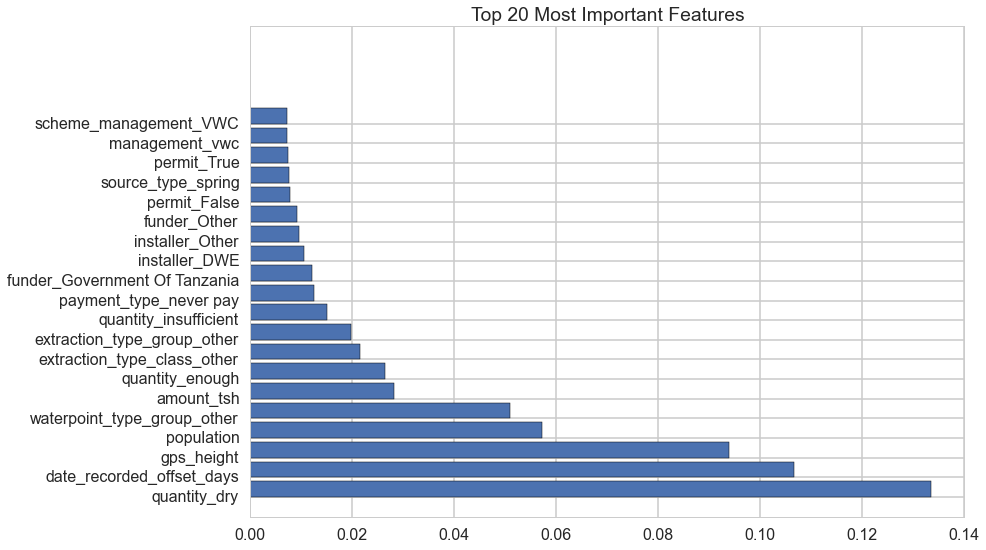

In [121]:
num_feats = range(1, len(top_feats)+1)
plt.barh(num_feats, top_feats)
plt.yticks(num_feats, top_feat_names)
plt.title("Top 20 Most Important Features")

We again validate our earlier observation that the indicator for a dry quantity seems to be important in predicting well status. The indicators for the other quantity levels - enough and insufficient - also appear in our top 20 most important features. Our four quantitative variables appear within the top 6 most important features, but we assume this is partly due the transformation of our categorical variables into dummy indicators. 

We're definitely excited that Random Forest has made improvements on our best performance. We now move on to regression to see how we do there.

##  Regression

Because we have a categorical outcome variable with more than one outcome, we conduct a multinomial logistic regression with LASSO (specifically, L2) regularization.

We optimize for our best C and then fit a multinomial logistic regression model.

In [110]:
%time
clfmlr, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l2",solver='newton-cg', multi_class='multinomial'), 
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted,feat_cols, u'status_group',1, mask=mask)

CPU times: user 4 µs, sys: 10 µs, total: 14 µs
Wall time: 26.9 µs
using mask
BEST {'C': 100.0} 0.730182780183 [mean: 0.71611, std: 0.00431, params: {'C': 0.001}, mean: 0.72665, std: 0.00601, params: {'C': 0.01}, mean: 0.72953, std: 0.00478, params: {'C': 0.1}, mean: 0.72992, std: 0.00575, params: {'C': 1.0}, mean: 0.73011, std: 0.00581, params: {'C': 10.0}, mean: 0.73018, std: 0.00582, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.74
[[8578   61 1029]
 [ 970  102  226]
 [2382   41 4431]]
########################################################


We try using the 'lbfgs' solver instead of the 'newton-cg.'

In [111]:
%time
clfmlr_lbfgs, Xtrain_lbfgs, ytrain_lbfgs, Xtest_lbfgs, ytest__lbfgs = do_classify(LogisticRegression(penalty="l2",solver='lbfgs', multi_class='multinomial'), 
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted,feat_cols, u'status_group',1, mask=mask)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
using mask
BEST {'C': 10.0} 0.73063973064 [mean: 0.71614, std: 0.00428, params: {'C': 0.001}, mean: 0.72658, std: 0.00600, params: {'C': 0.01}, mean: 0.72946, std: 0.00490, params: {'C': 0.1}, mean: 0.73004, std: 0.00542, params: {'C': 1.0}, mean: 0.73064, std: 0.00588, params: {'C': 10.0}, mean: 0.73016, std: 0.00581, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.74
[[8580   62 1026]
 [ 972  102  224]
 [2376   43 4435]]
########################################################


We try using the one-vs-reset scheme instead of the multinomial scheme. The difference is that the OvR scheme does not put a constraint that the probabilities must sum to one, while the multinomial scheme does. Turns out that this model does not have much of a better fit.

In [112]:
%time
clflr_ovr, Xtrain_ovr, ytrain_ovr, Xtest_ovr, ytest__ovr = do_classify(LogisticRegression(penalty="l1",solver='newton-cg', multi_class='ovr'), 
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_formatted,feat_cols, u'status_group',1, mask=mask)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
using mask
BEST {'C': 100.0} 0.729196729197 [mean: 0.71097, std: 0.00438, params: {'C': 0.001}, mean: 0.72501, std: 0.00709, params: {'C': 0.01}, mean: 0.72903, std: 0.00542, params: {'C': 0.1}, mean: 0.72917, std: 0.00539, params: {'C': 1.0}, mean: 0.72915, std: 0.00562, params: {'C': 10.0}, mean: 0.72920, std: 0.00556, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.73
[[8550   39 1079]
 [ 992   57  249]
 [2376   21 4457]]
########################################################


We try the regression again on the non-standardized features.

In [114]:
df_copy = df_new.copy()

In [115]:
df_copy_formatted = pd.get_dummies(df_copy, columns=CATEGORICAL)

In [116]:
%time
clfmlr1, Xtrain1, ytrain1, Xtest1, ytest1 = do_classify(LogisticRegression(penalty="l2",solver='newton-cg', multi_class='multinomial'), 
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_copy_formatted,feat_cols, u'status_group',1, mask=mask)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
using mask
BEST {'C': 100.0} 0.730182780183 [mean: 0.71611, std: 0.00431, params: {'C': 0.001}, mean: 0.72665, std: 0.00601, params: {'C': 0.01}, mean: 0.72953, std: 0.00478, params: {'C': 0.1}, mean: 0.72992, std: 0.00575, params: {'C': 1.0}, mean: 0.73011, std: 0.00581, params: {'C': 10.0}, mean: 0.73018, std: 0.00582, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.74
[[8578   61 1029]
 [ 970  102  226]
 [2382   41 4431]]
########################################################


In [117]:
%time
clfmlr_lbfgs1, Xtrain_lbfgs1, ytrain_lbfgs1, Xtest_lbfgs1, ytest__lbfgs1 = do_classify(LogisticRegression(penalty="l2",solver='lbfgs', multi_class='multinomial'), 
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df_copy_formatted,feat_cols, u'status_group',1, mask=mask)

CPU times: user 4 µs, sys: 10 µs, total: 14 µs
Wall time: 37.9 µs
using mask
BEST {'C': 10.0} 0.73063973064 [mean: 0.71614, std: 0.00428, params: {'C': 0.001}, mean: 0.72658, std: 0.00600, params: {'C': 0.01}, mean: 0.72946, std: 0.00490, params: {'C': 0.1}, mean: 0.73004, std: 0.00542, params: {'C': 1.0}, mean: 0.73064, std: 0.00588, params: {'C': 10.0}, mean: 0.73016, std: 0.00581, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.73
Accuracy on test data:     0.74
[[8580   62 1026]
 [ 972  102  224]
 [2376   43 4435]]
########################################################


Unfortunately, neither the one-vs-reset nor the multinomial scheme appears to have outdone our Random Forest. The accuracies continue to hover near 75%. Having finished our analysis, let's summarize all of our models.  

# Summary of Models

We take the best accuracies from each model and combine them into df_comparison to compare. We created some of the models in different notebooks, so we manually collected the accuracy information and put it into barchart.csv to plot.

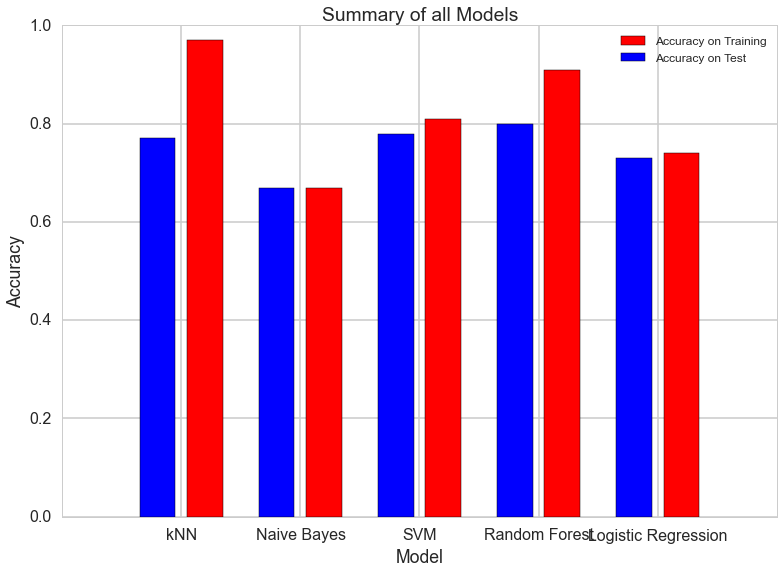

In [122]:
df_comparison = pd.read_csv("barchart.csv")

pos=np.arange(len(df_comparison['Model']))
plt.bar(pos+0.2, df_comparison['Accuracy on Training'],align='center',color='r',width=0.3,label = 'Accuracy on Training')
plt.bar(pos-0.2, df_comparison['Accuracy on Test'],align='center',color='b',width=0.3,label = 'Accuracy on Test')
plt.xticks(pos, df_comparison['Model'])
plt.legend(fontsize=12)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Summary of all Models")

##  Future Directions

We have a few things we would be interested in pursuing further with more time. They include the following:
1. **Feature Selection.** In the Naive Bayes model, we removed a few features that were correlated/redundant to try to improve our model. This did in fact improve the model, but the way we chose to remove them was simply to take away the ones wiht a clear nesting structure. We could potentially choose another feature selection technique, such as correlation threshold, etc. We would also look into feature selection for the multinomial logistic regression as well.
2. **Mixed Naive Bayes.** We ended up choosing an ad hoc way of combining all the variables together, since we had both quantitative and categorical variables. Specifically, we changed our quantitative variables to categorical ones, but it would be interesting to look more into specific Mixed Naive Bayes approaches that would not force us to lose information by changing the form of our variable.
3. **Multilevel Modeling.** Due to the complexity of unpacking the multilevel logistic model created with sklearn and the absence of Python libraries for multilevel modeling, we ultimately did not add other levels to our regression. With more time, we would look into encoding these hierarchical relationships and correlation structures ourselves.
4. **Visualizing accuracy over the space of our hyperparameters.** In all our above models, we used GridSearchCV to find the optimal hyperparameters for our classifiers. These are not always guaranteed to be the best choices, especially given the noise in the dataset. To ensure we were selecting appropriate hyperparameters and not random values that happen to be a spike in the curve due to noise, we would plot the accuracy of our model for the range of values of our hyperparameters to know that the model and we ourselves were choosing the appropriate values.
5. **Incorporation of geographic location into Models.** As we noted with Iringa, perhaps there is something to be said about specific geographic locations, whether it is around another geographic feature, such as a body of water, or whether latitude or longitude may have an effect. While we were able to see this visually, it may be interesting to incorporate into our models. 
6. **Polynomial SVM.** While we did not have the opportunity to run the other algorithm for SVM's, polynomial SVM, we would love to attempt this method in the future. Of course, we would also optimize for the degree.
6. **Ensemble Method.** While we did not have the time to build an ensemble method here, due to the complication of having three response variables, such that we would have to expand upon a simple linear regression. We would hope that perhaps, this ensemble would improve on our current best model, the Random Forest, and aid in prediction.